# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "eI4qKuy2jETIr1YT1VrNwczRP"
CONSUMER_SECRET = "gcQhulnmylPplR517a4lEZRC52myeS7oRrPil1sD0Zf1jeyWyb"

ACCESS_TOKEN_KEY = "3819130643-iwnyEY9D3YLmYaCGQVy9Qy9fkf8BI7XNqQIdNPF"
ACCESS_TOKEN_SECRET = "ASmwVh4GDBm7BkaxHJoEz7OxO9UVLqthJzvB39YuPyH5p"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [2]:
import re
import json

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [3]:
timeline = json.load(open("tweets.json", "r"))

In [4]:
def get_user_tweets(user_id):
    msgs = timeline[str(user_id)]
    """returns list of tweets as dicts"""
    return [{'lang': msg.get('lang', 'und'),
             'favorited': msg.get('favorited', False),
             'truncated': msg.get('truncated', False),
             'text': msg.get('text', ''),
             'created_at': msg.get('created_at', ''),
             'retweeted': msg.get('retweeted', False),
             'source': re.findall(r'>.+</a>', msg.get('source', '>undefined</a>'))[0][1:-4],
             'user': {'id': user_id},
             'id': msg.get('id', 0)} for msg in msgs]

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
def get_words(text):
    """returns list of words"""
    text_nolinks = re.sub(r'http[^ ]+', '', text)
#     words = re.split(r'[,.:;"\' !?\n\r\t#&<>\{\}\[\]\(\)+=\\/|`~$*%^]', text_nolinks)
    words = re.split(r'[\W]', text_nolinks)
    return [word for word in words if len(word) > 0]

In [6]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
import nltk
# nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [8]:
wnl = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.SnowballStemmer('english')

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
def get_tokens(words):
    """returns list of tokens"""
    tokens = []
    for word in words:
        tmp = stemmer.stem(word.lower())
        tmp = wnl.lemmatize(tmp)
        if tmp not in stopwords:
            tokens.append(tmp)
            
    return tokens

In [11]:
print get_tokens(["here", "are", "different", "words"])

[u'differ', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [12]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [13]:
import sys

In [14]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    users = df_users['twitter_id'].values
    user_dicts = []
    leng = users.size
    for i, user in enumerate(users):
        tokens = []
        
        sys.stdout.write("Progress: %.2f%%\r" % (100.0 * (i + 1) / leng))
        sys.stdout.flush()
        sys.stdout.write("%d\r" % (user))
        
        tweets = get_user_tweets(user)

        for tweet in tweets:
            tokens += get_tweet_tokens(tweet['text'])

        uniq_tokens = np.unique(tokens, return_counts=True)
        user_dicts.append(dict(zip(uniq_tokens[0], uniq_tokens[1])))
        
        del(tokens)
    return users, user_dicts

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict
import json
import time
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL)


_time = time.time()
nb_stdout = sys.stdout
sys.stdout = open('/dev/stdout', 'w')
users, users_tokens = collect_users_tokens(df_users)
sys.stdout = nb_stdout
print(time.time() - _time)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

56.1025540829


Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [16]:
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens)

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [17]:
from wordcloud import WordCloud # https://github.com/amueller/word_cloud
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    twitter_mask = imread('twitter_mask.png', flatten=True)
    wc = WordCloud(width=3000, height=2000,
                   background_color='white',
                   font_path='./CabinSketch-Regular.ttf',
                   mask=twitter_mask)
    
    wfreq = np.array(vs.sum(axis=0), dtype=np.int).ravel()
    words = np.array(v.get_feature_names())
    sorted_freq = np.argsort(wfreq)[-1::-1]
    wc.fit_words(zip(words[sorted_freq], wfreq[sorted_freq]))
    
    plt.figure(figsize=(30, 20))
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig('twitter_wordcloud.png', dpi=300)

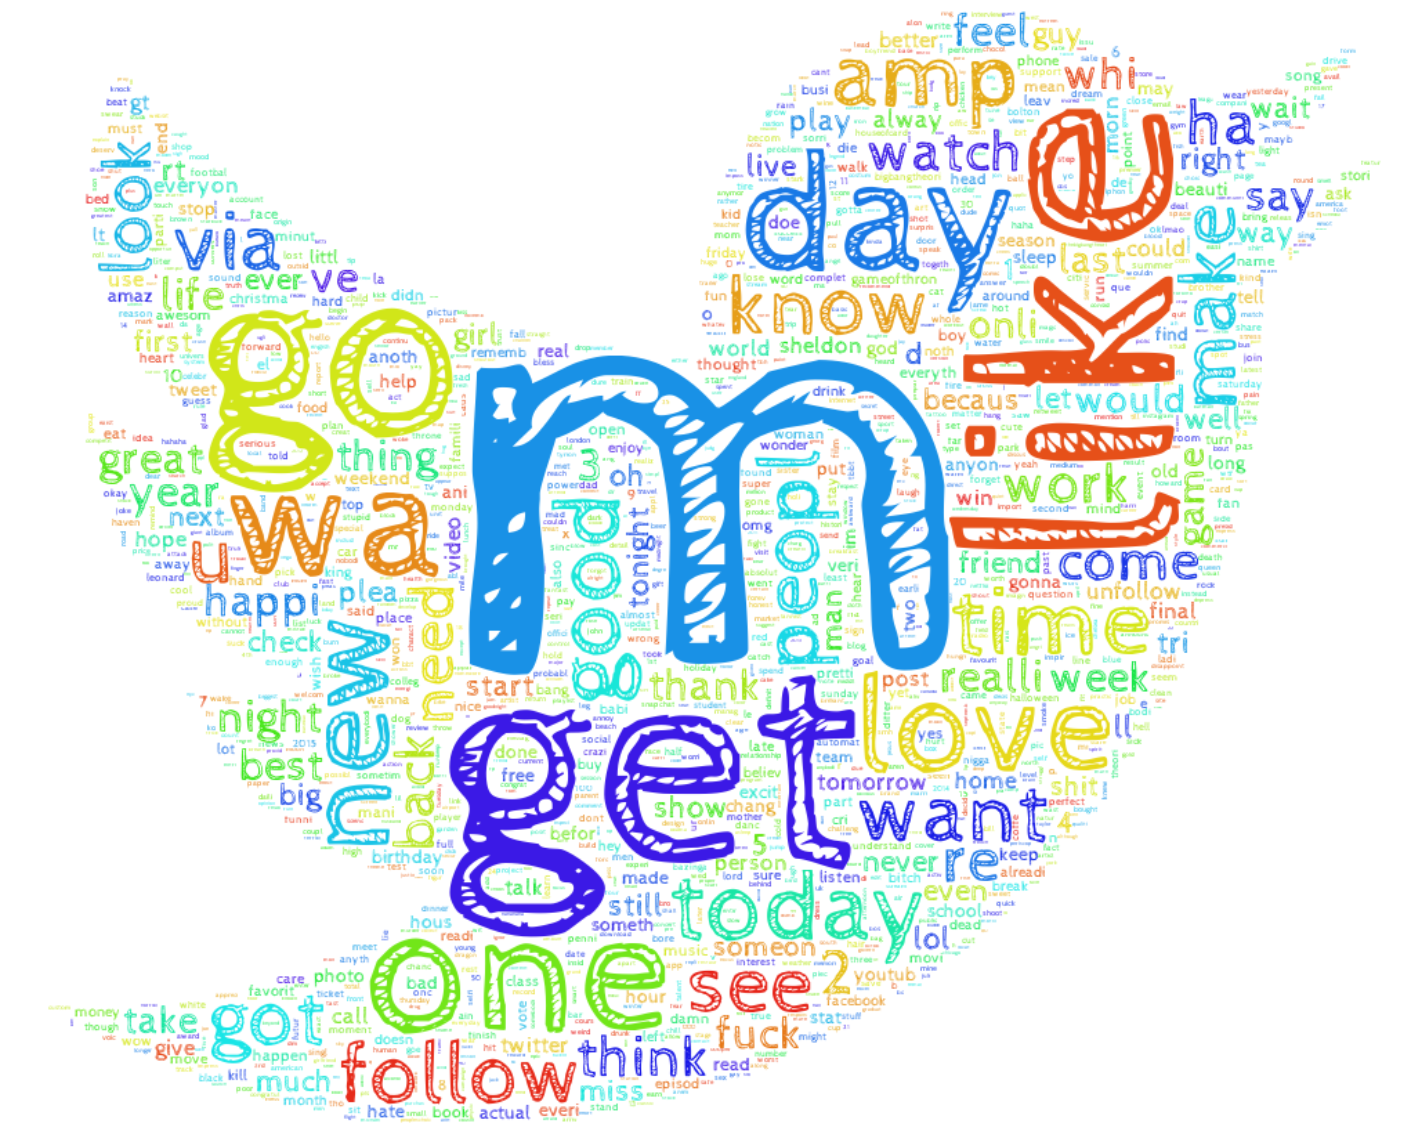

In [27]:
draw_tag_cloud(v, vs)

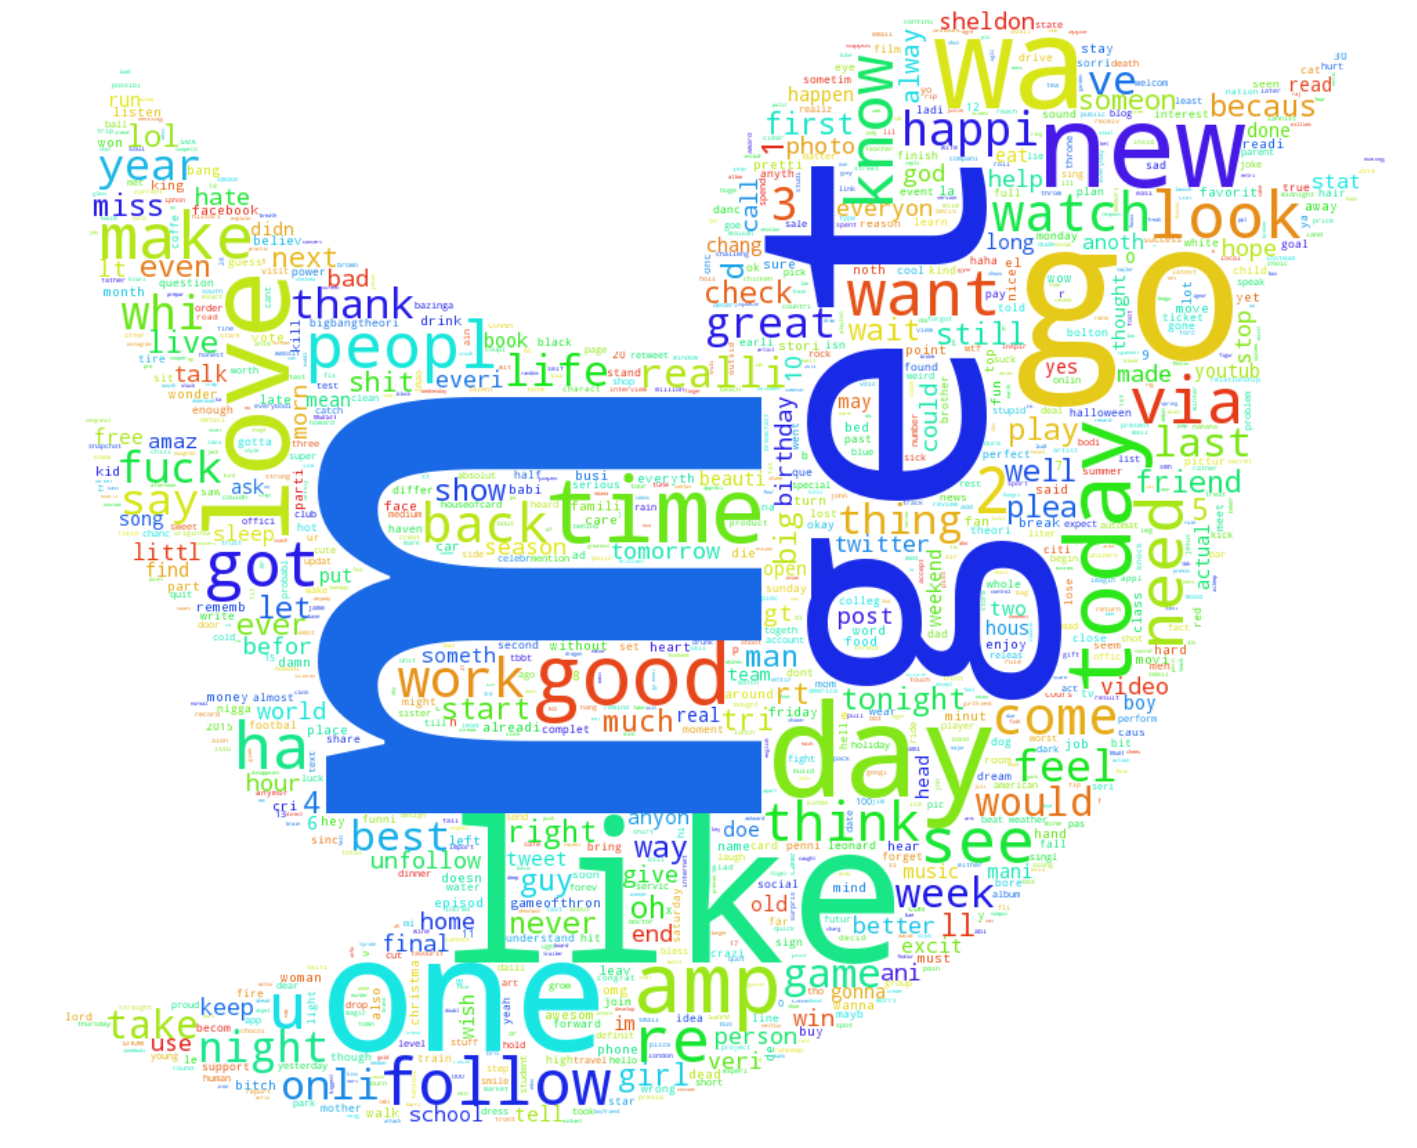

In [25]:
draw_tag_cloud(v, vs)